In [511]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [512]:
class TreeNode:
    def __init__(self):
        self.split_value = None  # Value to split on
        self.split_column = None  # Column index to split on
        self.left = None  # Left child node (TreeNode)
        self.right = None  # Right child node (TreeNode)
        self.is_leaf = False  # Indicator if this node is a leaf
        self.label = None  # Class label if this node is a leaf

In [513]:
data = np.loadtxt("Dbig.txt")
np.random.shuffle(data)
candidate_training_set = data[:8192]
test_set = data[8192:]
D_32 = candidate_training_set[:32]
D_128 = candidate_training_set[:128]
D_512 = candidate_training_set[:512]
D_2048 = candidate_training_set[:2048]
D_8192 = candidate_training_set

In [514]:
def CalculateEntropy(data_label):
    _, counts = np.unique(data_label, return_counts=True)
    prob = counts/len(data_label)
    entropy = -np.sum(prob * np.log2(prob))
    return entropy

In [515]:
def splitEntropy(D,split,col):
    subgroup1 = D[D[:, col] < split]  
    subgroup2 = D[D[:, col] >= split] 
    proportion1 = subgroup1.shape[0]/D.shape[0]
    proportion2 = subgroup2.shape[0]/D.shape[0]
    entropy_split = 0
    if proportion1 > 0:  # This will ensure log(0) is not calculated.
        entropy_split -= proportion1 * np.log2(proportion1)
    if proportion2 > 0:
        entropy_split -= proportion2 * np.log2(proportion2)
    # print(proportion1,proportion2,entropy_split)
    return entropy_split

In [516]:
def InfoGain(D,split,col):
    entropy_beforesplit = CalculateEntropy(D[:,2])
    subgroup1 = D[D[:, col] < split]  
    subgroup2 = D[D[:, col] >= split] 
    # print(split)
    # print(subgroup1)
    # print(subgroup2) 
    proportion1 = subgroup1.shape[0]/D.shape[0]
    proportion2 = subgroup2.shape[0]/D.shape[0]
    entropy_subgroup1 = CalculateEntropy(subgroup1[:,2])
    entropy_subgroup2 = CalculateEntropy(subgroup2[:,2])
    entropy_aftersplit = proportion1*entropy_subgroup1 + proportion2*entropy_subgroup2
    infogain = entropy_beforesplit - entropy_aftersplit
    return infogain

In [517]:
def GainRatio(D,split,col):
    infogain = InfoGain(D,split,col)
    entropy_split = splitEntropy(D,split,col)
    if entropy_split == 0:
        print(col,split)
    gainratio = infogain/entropy_split
    return gainratio

In [518]:
def DetermineCandidateSplits(D,col_num):
    C = []
    print("at this time, D is \n", D.shape)
    for col in range(col_num):
        sorted_indices = np.argsort(D[:, col])
        sorted_data = D[sorted_indices]
        # print("at col", col, "the sorted data is \n", sorted_data.shape)
        for i in range(len(sorted_data)-1):
            if sorted_data[i,2] != sorted_data[i+1,2]:
                entropy_split = splitEntropy(sorted_data,sorted_data[i+1,col],col)
                # print("at i = ",i," cut is ",sorted_data[i+1,col],", entropy is ", entropy_split)
                if entropy_split != 0:
                    C.append(sorted_data[i+1,col])
        # print(f"for col {col}, C is {C}, len(C) is {len(C)}")
        if col == 0:
            C1_len = len(C)
    
    print("Finally, C is ", C,", C1_len is ",C1_len)
    return C,C1_len

In [519]:
def FindBestSplit(D,C,C1_len):
    best_split = C[0]
    best_gainratio = 0
    best_col = 0
    for i in range(len(C)):
        cut = C[i]
        if i < C1_len:
            col = 0
        else:
            col = 1
        current_gainratio = GainRatio(D,cut,col)
        if current_gainratio > best_gainratio:
            best_split = C[i]
            best_col = col
            best_gainratio = current_gainratio
        # print(f"for cut {cut}, the gainratio is {current_gainratio}, current best gainratio is {best_gainratio}")
    return best_split,best_col

In [520]:
def StoppingCriteria(D,C,C1_len):
    print("Checking stopping Creteria:")
    met = 0 # 0 is not met, 1 is met
    # the node is empty
    if D.size == 0:
        print("D is empty. ERROR!")
        met = 1
        return met
    # all splits have zero gain ratio (if the entropy of the split is non-zero)
    all_zero = 1
    C,C1_len = DetermineCandidateSplits(D,col_num=2)
    for i in range(len(C)):
        cut = C[i]
        if i < C1_len:
            col = 0
        else:
            col = 1
        if GainRatio(D,cut,col) != 0:
            all_zero = 0
    if all_zero == 1:
        met = 1
        
    # the entropy of any candidates split is zero
    if len(C) == 0:
        met = 1
    print(f"Finished Checking Stopping Criteria, met is {met}")
    return met

In [521]:
def majority_class(D):
    labels = D[:, 2]
    unique, counts = np.unique(labels, return_counts=True)
    return unique[np.argmax(counts)]

In [522]:
def MakeSubtree(D):
    node = TreeNode()
    C,C1_len = DetermineCandidateSplits(D,2)
    make_leaf = StoppingCriteria(D,C,C1_len)
    if make_leaf == 1:
        node.is_leaf = True
        node.label = majority_class(D)  
        print(f"this node {D} is made a leaf! Leaf label is {node.label}\n")
        return node
    else:
        best_split, best_col = FindBestSplit(D, C, C1_len)
        node.split_value = best_split
        node.split_column = best_col

        left_data = D[D[:, best_col] < best_split]
        right_data = D[D[:, best_col] >= best_split]
        print(f"at this time, we split to left and right data according to best split {best_split} at col {best_col}:")
        print("Left data is: \n", left_data.shape)
        print("Right data is: \n", right_data.shape)
        print("\n")

        node.left = MakeSubtree(left_data)
        node.right = MakeSubtree(right_data)
    return node

In [530]:
root_node1 = MakeSubtree(D_32)
root_node2 = MakeSubtree(D_128)
root_node3 = MakeSubtree(D_512)
root_node4 = MakeSubtree(D_2048)
root_node5 = MakeSubtree(D_8192)

at this time, D is 
 (32, 3)
Finally, C is  [-0.935015, -0.87173, -0.868307, -0.54171, -0.524385, -0.328251, -0.325784, 0.02052, 0.020911, 0.021384, 0.359844, 0.905577, 1.015819, 1.109717, -0.578856, -0.569791, -0.540558, -0.334679, -0.303551, -0.141942, -0.02396, 1.090238, 1.215435, 1.359764] , C1_len is  14
Checking stopping Creteria:
at this time, D is 
 (32, 3)
Finally, C is  [-0.935015, -0.87173, -0.868307, -0.54171, -0.524385, -0.328251, -0.325784, 0.02052, 0.020911, 0.021384, 0.359844, 0.905577, 1.015819, 1.109717, -0.578856, -0.569791, -0.540558, -0.334679, -0.303551, -0.141942, -0.02396, 1.090238, 1.215435, 1.359764] , C1_len is  14
Finished Checking Stopping Criteria, met is 0
at this time, we split to left and right data according to best split -0.578856 at col 1:
Left data is: 
 (10, 3)
Right data is: 
 (22, 3)


at this time, D is 
 (10, 3)
Finally, C is  [] , C1_len is  0
Checking stopping Creteria:
at this time, D is 
 (10, 3)
Finally, C is  [] , C1_len is  0
Finished Ch

In [524]:
def gather_tree_info(node, node_counter):
    current_node = node_counter
    node_info = {}
    left_info, right_info = {}, {}

    if node.is_leaf:
        node_info[current_node] = f"Leaf Node {current_node}: Class {int(node.label)}"
        return node_info, node_counter

    if node.left is not None:
        left_info, node_counter = gather_tree_info(node.left, node_counter + 1)
    
    if node.right is not None:
        right_info, node_counter = gather_tree_info(node.right, node_counter + 1)
    
    left_child = current_node + 1
    right_child = left_child + len(left_info)

    node_info[current_node] = f"Internal Node {current_node}: If feature {node.split_column + 1} <= {node.split_value} then go to Node {left_child}, else go to Node {right_child}"
    node_info.update(left_info)
    node_info.update(right_info)

    return node_info, node_counter

def visualize_tree(root):
    tree_info, _ = gather_tree_info(root, 0)
    
    # Print nodes in order
    for i in range(len(tree_info)):
        print(tree_info[i])

In [532]:
def predict_tree(node, sample):
    """Use the decision tree to predict a single sample."""
    if node.is_leaf:
        return node.label
    
    if sample[node.split_column] <= node.split_value:
        return predict_tree(node.left, sample)
    else:
        return predict_tree(node.right, sample)

def visualize_decision_boundaries(root, X):
    # Create a grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.2
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.2
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    # Predict each grid point's label
    Z = np.apply_along_axis(lambda sample: predict_tree(root, sample), 1, np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], edgecolors='k', marker='o')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Tree Classifier')
    plt.show()

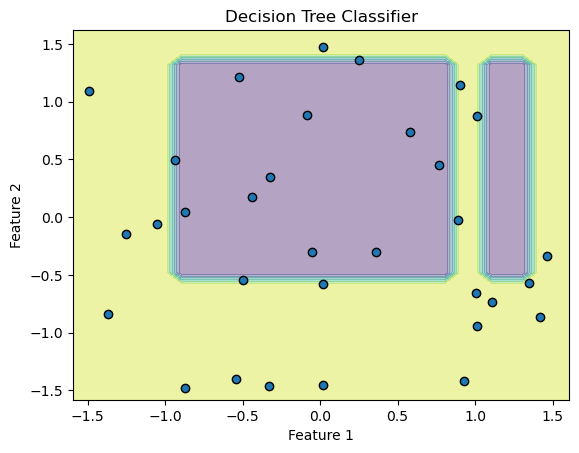

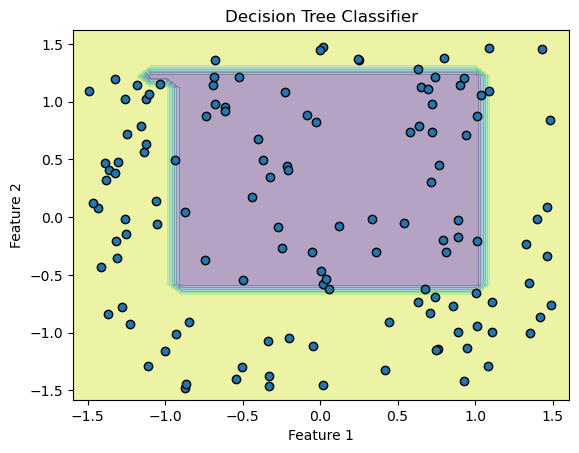

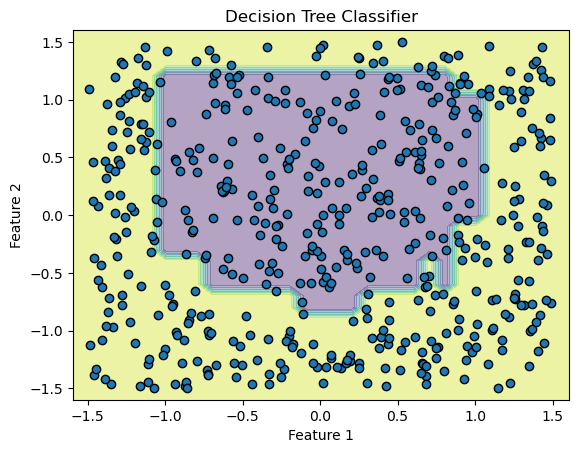

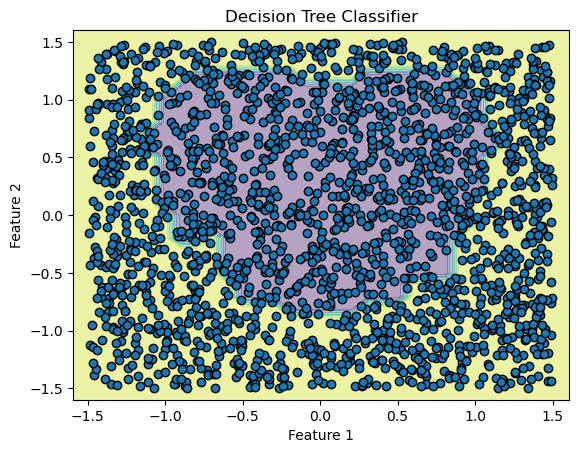

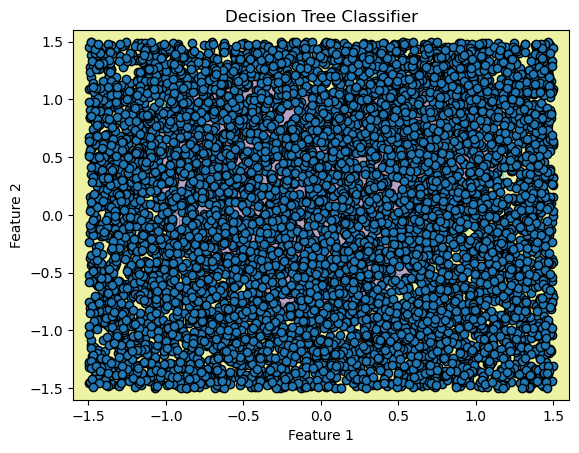

In [533]:
visualize_decision_boundaries(root_node1, D_32)
visualize_decision_boundaries(root_node2, D_128)
visualize_decision_boundaries(root_node3, D_512)
visualize_decision_boundaries(root_node4, D_2048)
visualize_decision_boundaries(root_node5, D_8192)

In [534]:
def ComputeTestError(node, test_data):
    predicted_labels = [predict_tree(node, sample) for sample in test_data]
    true_labels = test_data[:, -1]
    err_n = sum(predicted_labels != true_labels) / len(test_data)
    return err_n

In [535]:
def PlotLearningCurve(ns, errors):
    plt.figure(figsize=(10, 6))
    plt.plot(ns, errors, '-o', color='blue')
    plt.xlabel('Number of Nodes (n)')
    plt.ylabel('Test Set Error (err_n)')
    plt.title('Learning Curve: n vs err_n')
    plt.grid(True)
    plt.show()

when n = 13, err_n is 0.1886061946902655
when n = 33, err_n is 0.10287610619469026
when n = 63, err_n is 0.054756637168141595
when n = 105, err_n is 0.02654867256637168
when n = 271, err_n is 0.014380530973451327


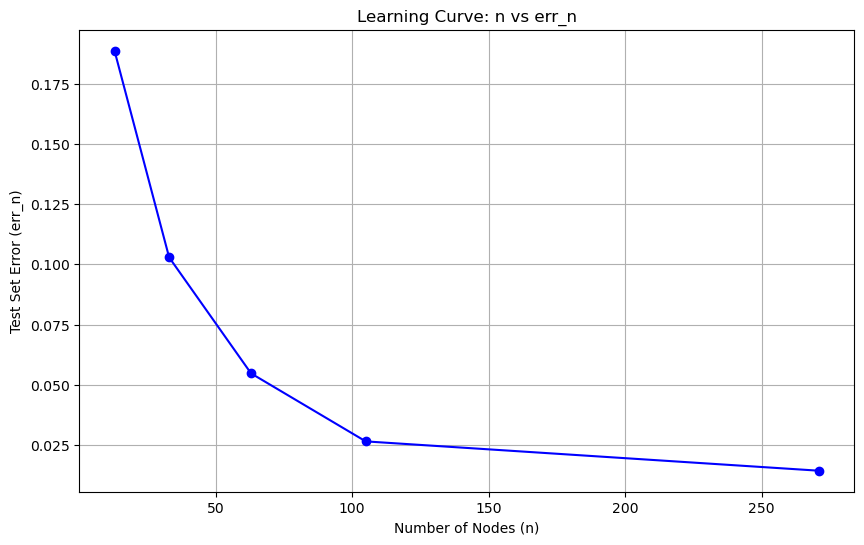

In [537]:
def CountNodes(node):
    if node.is_leaf:
        return 1
    return 1 + CountNodes(node.left) + CountNodes(node.right)

err_n1 = ComputeTestError(root_node1, test_set)
n1 = CountNodes(root_node1)

err_n2 = ComputeTestError(root_node2, test_set)
n2 = CountNodes(root_node2)

err_n3 = ComputeTestError(root_node3, test_set)
n3 = CountNodes(root_node3)

err_n4 = ComputeTestError(root_node4, test_set)
n4 = CountNodes(root_node4)

err_n5 = ComputeTestError(root_node5, test_set)
n5 = CountNodes(root_node5)

ns = [n1,n2,n3,n4,n5]
errors = [err_n1,err_n2,err_n3,err_n4,err_n5]

for i in range(5):
    print(f"when n = {ns[i]}, err_n is {errors[i]}")

PlotLearningCurve(ns, errors)